# Pan-cancer (PC) plasma proteome Paper — Figure 5

This Jupyter Notebook (with Python 3 kernel) contained the code for the proteomic tumor biomarker candidates selection

Input files:  
* The categorical clinical file: category.csv
* The continuous clinical fille: continuous.csv
* The PC proteome file: proteome.csv

Output figures:  
* Figure S8b, 5c, 5d, 5e

In [1]:
from utils import *
paths = ['../figure/figure5', '../documents/figure5']
for path in paths:
    if not os.path.isdir(path):
        os.makedirs(path)

a = Analysis('../')

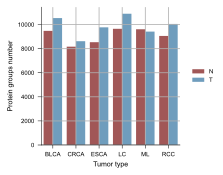

In [2]:
a.set_param('group', dataset_type='tissue_proteome', group_name='Sample type', file_type='tissue_category')
plotdata = a.merge_data_group(a.table.index).groupby('Sample type').sum().replace(0, np.nan).count(axis=1).rename('Count').reset_index()
plotdata = pd.concat([plotdata['Sample type'].str.split('_', expand=True).rename(columns={0: 'Tumor type', 1: 'Sample type'}), plotdata['Count']], axis=1)
plotdata.to_csv('../documents/figure5/Source_data_FigS8b.csv')

ax = barplot(plotdata, dodge=True, ticklabels_hide=[], ticklabels_format=[], palette=['darkred', MCMAP[1]], alpha=.7, figsize=(2.5, 2.5))
ax.set_ylabel('Protein groups number')
ax.grid()
ax.get_figure().savefig('../figure/figure5/FigS8b.pdf', bbox_inches='tight')

In [3]:
from collections import defaultdict
from my_tools_beta.statistic import fdr

tumor_types = ['LC', 'ML', 'CRCA', 'ESCA', 'RCC', 'BLCA']
value_ = 0.2
test_method = 'ttest'

dataset_types = ['tmp', 'tissue_proteome']
file_types = ['category', 'tissue_category']
group_names = [['sample_annot', 'Sample type'], 'Sample type']
up_genes = defaultdict(dict)
down_genes = defaultdict(dict)
names = ['plasma', 'tissue']

a._data['tmp'] = a.proteome.divide(a.proteome.median())

for tumor_type in tumor_types:
    part_elements = [[['discovery_normal', 'discovery_tumor'], ['normal', tumor_type]], [tumor_type+'_T', tumor_type+'_N']]
    dividends = ['discovery_tumor_'+tumor_type, tumor_type+'_T']
    for name, dataset_type, file_type, group_name, part_element, dividend in zip(names, dataset_types, file_types, group_names, part_elements, dividends):
        a.set_param('group', dataset_type=dataset_type, file_type=file_type, group_name=group_name, part_element=part_element, dividend=dividend, param_method='median', statistic_method='log2')
        if tumor_type == 'ML':
            metric = 'pvalues'
            sig_thresh = 0.01
        else:
            metric = 'pvalues'
            sig_thresh = 0.01

        label_ = 'cohen_d'
        label1_ = a.table.columns[2]
        query_condition1 = "abs({})>{}&{}_{}<{}&{}>1".format(label_, value_, test_method, metric, sig_thresh, label1_)
        query_condition2 = "abs({})>{}&{}_{}<{}&{}<1".format(label_, value_, test_method, metric, sig_thresh, label1_)
        
        gene = a.table.query(query_condition1).index
        up_genes[tumor_type][name] = gene
        gene = a.table.query(query_condition2).index
        down_genes[tumor_type][name] = gene
pd.DataFrame().from_dict(up_genes, orient='index').stack().apply(pd.Series).T.to_csv('../documents/figure5/Source_data_Fig5c.csv')
pd.DataFrame().from_dict(down_genes, orient='index').stack().apply(pd.Series).T.to_csv('../documents/figure5/Downregulated_candicates.csv')

core_marker_candidates = {}
for tumor_type in tumor_types:
    core_marker_candidates[tumor_type] = np.intersect1d(*list(up_genes[tumor_type].values()))
core_marker_candidates_df = pd.DataFrame().from_dict(core_marker_candidates, orient='index')
core_marker_candidates_df = core_marker_candidates_df.rename_axis('Tumor_type').stack().droplevel(1).rename('Gene').reset_index().set_index('Gene')
core_marker_candidates_df.to_csv('../documents/figure5/core_marker_candidates_df.csv')

count_ = {}
up_core_marker_without_benign = {}
for tumor_type in tumor_types:
    a.set_param('group', dataset_type='tmp', group_name=['sample_annot', 'Sample type'], part_element=[['discovery_tumor', 'discovery_benign'], [tumor_type, tumor_type+'_benign']], param_method='median', file_type='category', dividend='discovery_tumor_'+tumor_type)
    markers = core_marker_candidates_df.query("`Tumor_type`==@tumor_type").index
    query_table = a.table.reindex(markers).query("discovery_tumor_{}_median>discovery_benign_{}_benign_median&ttest_pvalues<0.05".format(tumor_type, tumor_type))
    up_core_marker_without_benign[tumor_type] = query_table.index.tolist()
    count_[tumor_type] = query_table.shape[0]
count_df = pd.DataFrame().from_dict(count_, orient='index', columns=['Count']).rename_axis('Sample type')
count_df.to_csv('../documents/figure5/Source_data_Fig5d.csv')

up_core_marker_without_benign_df = pd.DataFrame().from_dict(up_core_marker_without_benign, orient='index').rename_axis('Sample type').stack().droplevel(1).rename('Proteins').to_frame()
up_core_marker_without_benign_df.to_csv('../documents/figure5/core_markers_df.csv')

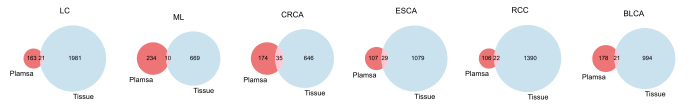

In [4]:
fig, axs = plt.subplots(1, len(tumor_types), figsize=(12, 2))
for ax, tumor_type in zip(axs, tumor_types):
    vennplot([up_genes[tumor_type]['plasma'], up_genes[tumor_type]['tissue']], weighted=True, palette=(MCMAP[5], MCMAP[0]), ax=ax, labels_name=['Plamsa', 'Tissue'])
    ax.set_title(tumor_type)
fig.savefig('../figure/figure5/Fig5c.pdf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


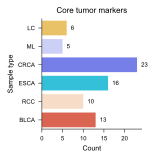

In [5]:
ax = barplot(count_df, orient='h', figsize=(1.8, 2), ticklabels_format=[], ticklabels_hide=[], palette=a._color_map['Sample type'], title='Core tumor markers')
for i, tumor_type in enumerate(tumor_types):
    ax.text(count_df.loc[tumor_type]+1, i+.1, s=count_df.loc[tumor_type, 'Count'])
ax.get_figure().savefig('../figure/figure5/Fig5d.pdf', bbox_inches='tight')

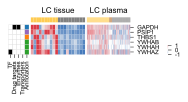

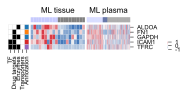

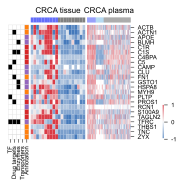

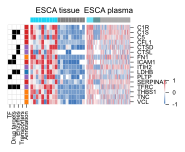

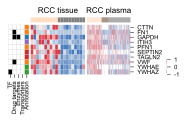

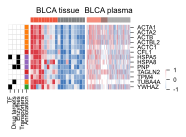

In [7]:
from collections import defaultdict
from functools import reduce

annot_table = pd.read_csv('../documents/figure5/protein_annot.csv', index_col=0)
annots_number = annot_table.Annotation.nunique()
palettes = sns.color_palette()
annot_colors = ['white', 'black']
annot_colors.extend(palettes[:annots_number])
annot_element = np.hstack((['No', 'Yes'], annot_table.Annotation.unique()))
transform_ = dict(zip(annot_element, range(len(annot_colors))))
annot_vmax = len(annot_colors)
annot_vmin = 0
a._data['tmp'] = a.proteome.reindex(a.category.query("sample_annot.str.contains('discovery')", engine='python').index, axis=1).dropna(how='all', axis=1)

dataset_types = ['tissue_proteome', 'tmp']
file_types = ['tissue_category', 'category']
group_names = ['Sample type', 'Sample type']
names = ['tissue', 'plasma']

for tumor_type in tumor_types:
    com = pd.DataFrame()
    proteins = up_core_marker_without_benign[tumor_type]
    part_elements = [[tumor_type+'_T', tumor_type+'_N'], [tumor_type, tumor_type+'_benign', 'normal']]
    dividends = [tumor_type+'_T', None]

    fig, axs = plt.subplot_mosaic("AABBBBBCCCCC", figsize=(2.4, len(proteins)*0.09))
    plotdata = annot_table.loc[proteins].applymap(lambda x: transform_.get(x))
    com = pd.concat([com, plotdata])
    annots = plotdata.columns

    heatmap(plotdata, cmap=annot_colors, vmax=annot_vmax, center=None, vmin=annot_vmin, square=False, cbar=False, yticklabels=False, linecolor='lightgray', linewidth=.25, ax=axs['A'], xticklabels=True)

    for ax_label, name, dataset_type, file_type, group_name, part_element, dividend in zip(['B', 'C'], names, dataset_types, file_types, group_names, part_elements, dividends):
        a.set_param('group', dataset_type=dataset_type, file_type=file_type, group_name=group_name, part_element=part_element, dividend=dividend, param_method='median', statistic_method='log2')
        pre_plotdata = a.merge_data_group(proteins).T
        plotdata = pre_plotdata.droplevel(0, 1).loc[:, part_element]
        if ax_label == 'B':
            params = {'yticklabels': False, 'cbar': False}
        else:
            params = {'cbar': True, 'cbar_kws': {'anchor': (4.5, 0), 'shrink': .3}}
        heatmap(plotdata, z_score=0, ax=axs[ax_label], **params)
        com = pd.concat([com, scipy.stats.zscore(plotdata, axis=1, nan_policy='omit')], axis=1)
        name_replace_ = dict(zip(['LC_benign', 'BLCA_benign', 'CRCA_benign', 'ML_benign', 'RCC_benign', 'ESCA_benign', 'normal'], ['Lung_benign', 'Bladder_benign', 'Colorectal_benign', 'Lymph_benign', 'Renal_benign', 'Esophagus_benign', 'Healthy control']))
        com.columns = com.columns.map(lambda x: name_replace_.get(x, x))
        com.to_csv(f'../documents/figure5/Source_data_Fig5e_{tumor_type}_{name}_heatmap.csv')

        pos_ = axs[ax_label].get_position()
        pos_use = (pos_.y1-pos_.y0)/len(proteins)
        ax_annot = fig.add_axes([pos_.x0, pos_.y1+pos_use/2, pos_.x1-pos_.x0, pos_use])
        
        if name == 'tissue':
            plotdata = a.tissue_category.loc[pre_plotdata.columns.get_level_values(0), ['Sample type']].T.replace(part_element, range(len(part_element)))
            annot_cmap = [a._color_map['Sample type'][type_] for type_ in [tumor_type, 'normal']]
        else:
            plotdata = a.category.loc[pre_plotdata.columns.get_level_values(0), ['Sample type']].T.replace(part_element, range(len(part_element)))
            annot_cmap = [a._color_map['Sample type'][type_] for type_ in part_element]
        heatmap(plotdata, ax=ax_annot, cbar=False, cmap=annot_cmap, yticklabels=False, vmax=None, vmin=None, center=None)
        axs[ax_label].set_title('{} {}'.format(tumor_type, name), pad=12)
    axs['C'].tick_params(left=False, right=True, labelright=True, labelleft=False, labelrotation=0)
    fig.savefig(f'../figure/figure5/Fig5e_{tumor_type}.pdf', bbox_inches='tight')
del a._data['tmp']